# Analyze *falcon* clusters

This notebook can be used to analyze clusters generated by *falcon*. For the moment, it can:
* Show stats about the clusters: the number of clusters, the average size...
* Plot

In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import spectrum_utils.plot as sup
from tqdm.notebook import tqdm

from ms_io import ms_io
import bittremieux_utils

### Open the file and show basic stats

In [2]:
def basicStats(file):
    df = pandas.read_csv(file)
    clustMask = df['cluster'] != -1
    clustDf = df[clustMask]
    nClusteredSp = len(clustDf)
    propClusteredSp = nClusteredSp/len(df)
    nClusters = np.max(clustDf['cluster']) + 1

    print("Number of (non filtered) input spectra: {}".format(len(df)))
    print("Number of clustered spectra: {0} ({1:.2f}%)".format(nClusteredSp, propClusteredSp*100))
    print("Number of clusters: {}".format(nClusters))
    print("Spectra per cluster: {}".format(nClusteredSp/nClusters))

In [3]:
path_cluster = os.path.join('/media/maesk/WD/falcon',
                        'PXD000561', # TODO
                        'nn',
                        'fragm_tol_0.05_hash_len_800',
                        'prec_tol_20')
eps_all = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
#eps_all = [0.01, 0.1]
min_sample = 3
file_labels = '/media/maesk/WD/MS/PXD000561/kim2014_ids.csv'
labels = pd.read_csv(file_labels)
#labels = None

In [4]:
num_clustered_all = []
num_noise_all = []
prop_clustered_all = []
prop_clustered_incorrect_all = []
homogeneity_all = []
completeness_all = []
clustersizes_all = []

for eps in tqdm(eps_all):
    file_clusters = os.path.join(path_cluster, f'clusters_eps_{eps}_minsample_{min_sample}.csv')
    clusters = bittremieux_utils.get_clusters_falcon(file_clusters, labels)
    num_clustered, num_noise, \
            prop_clustered, prop_clustered_incorrect, \
            homogeneity, completeness = bittremieux_utils.evaluate_clusters(clusters)
    num_clustered_all.append(num_clustered)
    num_noise_all.append(num_noise)
    prop_clustered_all.append(prop_clustered)
    prop_clustered_incorrect_all.append(prop_clustered_incorrect)
    homogeneity_all.append(homogeneity)
    completeness_all.append(completeness)

    clustersizes = clusters[clusters['cluster'] != -1].groupby(by='cluster').count()
    clustersizes_all.append(clustersizes['identifier'].to_numpy())

  0%|          | 0/6 [00:00<?, ?it/s]

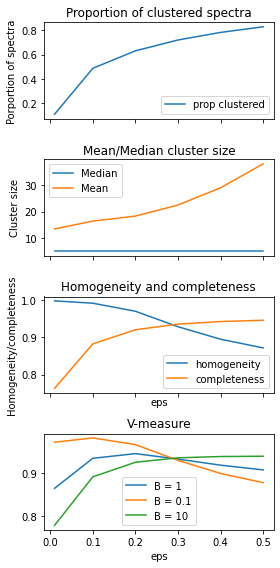

In [8]:
fig, axs = plt.subplots(4, 1, figsize=(4, 8), sharex=True)
#fig.suptitle('Cluster characteristics for several eps')

axs[0].plot(eps_all, prop_clustered_all, label='prop clustered')
axs[0].set(title='Proportion of clustered spectra', ylabel='Porportion of spectra')

axs[1].plot(eps_all, [np.median(cs) for cs in clustersizes_all], label='Median')
axs[1].plot(eps_all, [np.mean(cs) for cs in clustersizes_all], label='Mean')
axs[1].set(title='Mean/Median cluster size', ylabel='Cluster size')

axs[2].plot(eps_all, homogeneity_all, label='homogeneity')
axs[2].plot(eps_all, completeness_all, label='completeness')
axs[2].set(title='Homogeneity and completeness',
           xlabel='eps', ylabel='Homogeneity/completeness')

# Compute the V-measure
def v_measure(h, c, B):
    h, c = np.asarray(h), np.asarray(c)
    v = (1+B)*h*c/(B*h+c)
    return v.tolist()

axs[3].plot(eps_all, v_measure(homogeneity_all, completeness_all, 1), label='B = 1')
axs[3].plot(eps_all, v_measure(homogeneity_all, completeness_all, 0.1), label='B = 0.1')
axs[3].plot(eps_all, v_measure(homogeneity_all, completeness_all, 10), label='B = 10')
axs[3].set(title='V-measure', xlabel='eps')

for ax in axs:
    ax.legend()

plt.tight_layout()
plt.savefig('analyzeFalconClusters/analyzeCluster.png', dpi=300)
plt.show()

In [12]:
all_df = pd.DataFrame({'eps': eps_all,
                       'size_mean': [np.mean(cs) for cs in clustersizes_all],
                       'size_median': [np.median(cs) for cs in clustersizes_all],
                       'homogeneity': homogeneity_all,
                       'completeness': completeness_all,
                       'prop_clustered': prop_clustered_all})
all_df.to_csv('results_0.1/epsilon_vs_vmeasure.csv')

In [10]:
print([np.median(cs) for cs in clustersizes_all])

[5.0, 5.0, 5.0, 5.0, 5.0, 5.0]


### Plot the n first clusters

In [6]:
n_cl_plot = 0 # Number of clusters to plot

def extract_pkey(str):
    m = re.search('^.+:([0-9]+)+$', str)
    return int(m.group(1))



for i in range(0,n_cl_plot):
    currDf = clustDf[clustDf.cluster == i]
    identifiers = currDf.loc[:,"identifier"].tolist()
    precursor_charges = currDf.loc[:,"precursor_charge"].tolist()
    precursor_mzs = currDf.loc[:,"precursor_mz"].tolist()

    spf = ms_io.get_one_spectrum_from_pkl(dir_pkl, precursor_charges[0], precursor_mzs[0], identifiers[0])
    for j in range(1, len(identifiers)):
        fig, ax = plt.subplots(figsize=(12, 6))
        spectrum_top, spectrum_bottom = spf, ms_io.get_one_spectrum_from_pkl(dir_pkl,
                                                                            precursor_charges[j],
                                                                            precursor_mzs[j],
                                                                            identifiers[j])
        ax.set_title("Cluster {} ({}/{}) : {} and {}".format(i, j, len(identifiers)-1,
                     spectrum_top.identifier, spectrum_bottom.identifier))
        sup.mirror(spectrum_top, spectrum_bottom, ax=ax)
        plt.savefig(f"/home/maesk/tmp/{i}.png", dpi=300)
        plt.show()
        plt.close()